In [1]:
#!pip install -U numpy matplotlib qutip

import numpy as np
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional

from qutip import Bloch, Qobj
import matplotlib.pyplot as plt


In [2]:
def Rz(phi: float) -> np.ndarray:
    # Rz(phi) = exp(-i phi Z/2) = diag(e^{-i phi/2}, e^{+i phi/2})
    return np.array([[np.exp(-1j*phi/2), 0],
                     [0, np.exp(+1j*phi/2)]], dtype=np.complex128)

def Ry(theta: float) -> np.ndarray:
    # Ry(theta) = exp(-i theta Y/2)
    c = np.cos(theta/2)
    s = np.sin(theta/2)
    return np.array([[c, -s],
                     [s,  c]], dtype=np.complex128)

# User-specified gates:
I = np.eye(2, dtype=np.complex128)
H = Ry(np.pi/2) @ Rz(np.pi)
T = Rz(np.pi/4)

GATESET: Dict[str, np.ndarray] = {"I": I, "H": H, "T": T}
ACTIONS: List[str] = ["I", "H", "T"]

def apply_unitary_state(U: np.ndarray, psi: np.ndarray) -> np.ndarray:
    out = U @ psi
    out = out / np.linalg.norm(out)
    return out


In [3]:
from qutip import Qobj, sigmax, sigmay, sigmaz, expect

def bloch_xyz_from_psi(psi: np.ndarray) -> Tuple[float, float, float]:
    # QuTiP conventions guaranteed
    ket = Qobj(psi).unit()
    x = float(np.real(expect(sigmax(), ket)))
    y = float(np.real(expect(sigmay(), ket)))
    z = float(np.real(expect(sigmaz(), ket)))
    return x, y, z

def trajectory_bloch(seq: List[str], psi0: np.ndarray) -> List[Tuple[float,float,float]]:
    pts = [bloch_xyz_from_psi(psi0)]
    psi = psi0.copy()
    for a in seq:
        psi = apply_unitary_state(GATESET[a], psi)
        pts.append(bloch_xyz_from_psi(psi))
    return pts


def fidelity_pure(psi: np.ndarray, phi: np.ndarray) -> float:
    psi = psi / np.linalg.norm(psi)
    phi = phi / np.linalg.norm(phi)
    return float(np.abs(np.vdot(psi, phi))**2)



In [4]:
def angles_from_psi(psi: np.ndarray) -> Tuple[float, float]:
    psi = psi / np.linalg.norm(psi)

    a = float(np.clip(np.abs(psi[0]), 0.0, 1.0))
    theta = 2.0 * np.arccos(a)

    if np.abs(psi[0]) < 1e-12:
        phi = np.angle(psi[1])
    else:
        phi = np.angle(psi[1]) - np.angle(psi[0])

    phi = float(np.mod(phi, 2.0*np.pi))
    theta = float(np.clip(theta, 0.0, np.pi))
    return theta, phi

def psi_from_angles(theta: float, phi: float) -> np.ndarray:
    return np.array([np.cos(theta/2.0),
                     np.exp(1j*phi) * np.sin(theta/2.0)], dtype=np.complex128)

@dataclass(frozen=True)
class PureGrid:
    k: int

    @property
    def eps(self) -> float:
        return np.pi / self.k

    def num_states(self) -> int:
        if self.k < 3:
            raise ValueError("k must be >= 3")
        return 2 + (self.k - 2) * (2*self.k - 1)

    def encode(self, l: int, m: int) -> int:
        if l == 0:
            return 0
        if l == self.k - 1:
            return 1
        mmax = 2*self.k - 1
        return 2 + (l - 1) * mmax + m

    def decode(self, sid: int) -> Tuple[int,int]:
        if sid == 0:
            return 0, 0
        if sid == 1:
            return self.k - 1, 0
        sid2 = sid - 2
        mmax = 2*self.k - 1
        l = 1 + sid2 // mmax
        m = sid2 % mmax
        return int(l), int(m)

    def state_id_from_angles(self, theta: float, phi: float) -> int:
        eps = self.eps
        theta = float(np.clip(theta, 0.0, np.pi))
        phi = float(np.mod(phi, 2.0*np.pi))

        l = int(theta // eps)
        l = min(max(l, 0), self.k - 1)

        if l == 0 or l == self.k - 1:
            return self.encode(l, 0)

        m = int(phi // eps)
        m = min(max(m, 0), 2*self.k - 2)
        return self.encode(l, m)

    def sample_angles_in_cell(self, sid: int, rng: np.random.Generator) -> Tuple[float, float]:
        l, m = self.decode(sid)
        eps = self.eps

        if l == 0:
            theta = rng.uniform(0.0, eps)
            phi = rng.uniform(0.0, 2.0*np.pi)
        elif l == self.k - 1:
            theta = rng.uniform(np.pi - eps, np.pi)
            phi = rng.uniform(0.0, 2.0*np.pi)
        else:
            theta = rng.uniform(l*eps, (l+1)*eps)
            phi = rng.uniform(m*eps, (m+1)*eps)

        return float(theta), float(phi)


In [5]:
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple
import numpy as np


@dataclass(frozen=True)
class Transition:
    s2: int
    p: float
    r: float


@dataclass
class MDP:
    num_states: int
    actions: List[str]
    transitions: Dict[str, List[List[Transition]]]


@dataclass
class Policy:
    actions: List[str]
    pi: np.ndarray
    V: np.ndarray

    def action_of(self, s: int) -> str:
        return self.actions[int(self.pi[s])]


@dataclass
class MonteCarloBuilderPure:
    grid: PureGrid
    actions: List[str]
    samples_per_state: int
    target_sid: int
    seed: int = 0
    make_target_absorbing: bool = True

    def build(self) -> MDP:
        rng = np.random.default_rng(self.seed)
        S = self.grid.num_states()
        transitions: Dict[str, List[List[Transition]]] = {
            a: [list() for _ in range(S)] for a in self.actions
        }

        for s in range(S):
            if self.make_target_absorbing and s == self.target_sid:
                for a in self.actions:
                    transitions[a][s] = [Transition(self.target_sid, 1.0, 1.0)]
                continue

            for a in self.actions:
                U = GATESET[a]
                counts: Dict[int, int] = {}
                for _ in range(self.samples_per_state):
                    th, ph = self.grid.sample_angles_in_cell(s, rng)
                    psi = psi_from_angles(th, ph)
                    psi2 = apply_unitary_state(U, psi)
                    th2, ph2 = angles_from_psi(psi2)
                    s2 = self.grid.state_id_from_angles(th2, ph2)
                    counts[s2] = counts.get(s2, 0) + 1

                out: List[Transition] = []
                denom = float(self.samples_per_state)
                for s2, c in counts.items():
                    p = c / denom
                    r = 1.0 if (s2 == self.target_sid) else 0.0
                    out.append(Transition(s2, p, r))

                psum = sum(tr.p for tr in out)
                if psum <= 0:
                    transitions[a][s] = [Transition(s, 1.0, 0.0)]
                else:
                    transitions[a][s] = [Transition(tr.s2, tr.p / psum, tr.r) for tr in out]

        return MDP(num_states=S, actions=self.actions, transitions=transitions)


@dataclass
class PolicyIteration:
    gamma: float = 0.99
    eval_tol: float = 1e-10
    max_eval_iters: int = 20000

    def solve(self, mdp: MDP) -> Policy:
        S = mdp.num_states
        pi = np.zeros(S, dtype=np.int64)
        V = np.zeros(S, dtype=np.float64)

        stable = False
        while not stable:
            for _ in range(self.max_eval_iters):
                delta = 0.0
                V_new = V.copy()
                for s in range(S):
                    a = mdp.actions[int(pi[s])]
                    v = 0.0
                    for tr in mdp.transitions[a][s]:
                        v += tr.p * (tr.r + self.gamma * V[tr.s2])
                    V_new[s] = v
                    delta = max(delta, abs(V_new[s] - V[s]))
                V = V_new
                if delta < self.eval_tol:
                    break

            stable = True
            for s in range(S):
                old = int(pi[s])
                best = old
                best_q = -1e300
                for a_idx, a in enumerate(mdp.actions):
                    q = 0.0
                    for tr in mdp.transitions[a][s]:
                        q += tr.p * (tr.r + self.gamma * V[tr.s2])
                    if q > best_q + 1e-15:
                        best_q = q
                        best = a_idx
                if best != old:
                    pi[s] = best
                    stable = False

        return Policy(actions=mdp.actions, pi=pi, V=V)


def _sid_of(grid: PureGrid, psi: np.ndarray) -> int:
    th, ph = angles_from_psi(psi)
    return grid.state_id_from_angles(th, ph)


def _apply_seq(seq: List[str], psi0: np.ndarray) -> np.ndarray:
    psi = psi0.copy()
    for a in seq:
        psi = apply_unitary_state(GATESET[a], psi)
    return psi


@dataclass
class GuidedBeamExtractor:
    grid: PureGrid
    actions: List[str]
    V: np.ndarray
    target_sid: int
    target_xyz: np.ndarray
    max_len: int = 200
    beam_width: int = 800
    per_sid_cap: int = 4
    length_penalty: float = 0.01
    dist_weight: float = 0.35
    seed: int = 0

    def extract(self, start_psi: np.ndarray) -> Optional[List[str]]:
        rng = np.random.default_rng(self.seed)

        start_sid = _sid_of(self.grid, start_psi)
        if start_sid == self.target_sid:
            return []

        beam: List[Tuple[float, np.ndarray, int, List[str]]] = [
            (float(self.V[start_sid]), start_psi.copy(), start_sid, [])
        ]

        for depth in range(1, self.max_len + 1):
            cand: List[Tuple[float, np.ndarray, int, List[str]]] = []

            for _, psi, sid, seq in beam:
                for a in self.actions:
                    psi2 = apply_unitary_state(GATESET[a], psi)
                    sid2 = _sid_of(self.grid, psi2)
                    seq2 = seq + [a]

                    if sid2 == self.target_sid:
                        psi_check = _apply_seq(seq2, start_psi)
                        if _sid_of(self.grid, psi_check) == self.target_sid:
                            return seq2
                        else:
                            continue

                    xyz2 = np.array(bloch_xyz_from_psi(psi2), dtype=np.float64)
                    dist = float(np.linalg.norm(xyz2 - self.target_xyz))
                    score = float(self.V[sid2]) - self.length_penalty * len(seq2) - self.dist_weight * dist
                    score += 1e-12 * float(rng.standard_normal())
                    cand.append((score, psi2, sid2, seq2))

            if not cand:
                return None

            cand.sort(key=lambda x: x[0], reverse=True)

            if self.per_sid_cap > 0:
                buckets: Dict[int, int] = {}
                filtered: List[Tuple[float, np.ndarray, int, List[str]]] = []
                for item in cand:
                    sid2 = item[2]
                    c = buckets.get(sid2, 0)
                    if c < self.per_sid_cap:
                        buckets[sid2] = c + 1
                        filtered.append(item)
                    if len(filtered) >= self.beam_width:
                        break
                beam = filtered
            else:
                beam = cand[: self.beam_width]

        return None


def extract_sequence_strict(
    grid: PureGrid,
    policy: Policy,
    target_sid: int,
    psi0: np.ndarray,
    psi_target: np.ndarray,
    actions: List[str],
    seed: int = 0,
) -> Optional[List[str]]:
    target_xyz = np.array(bloch_xyz_from_psi(psi_target), dtype=np.float64)

    for bw, ml, dw, lp in [
        (400, 120, 0.45, 0.010),
        (800, 160, 0.40, 0.010),
        (1600, 220, 0.35, 0.008),
        (2400, 260, 0.30, 0.008),
    ]:
        seq = GuidedBeamExtractor(
            grid=grid,
            actions=actions,
            V=policy.V,
            target_sid=target_sid,
            target_xyz=target_xyz,
            max_len=ml,
            beam_width=bw,
            per_sid_cap=4,
            length_penalty=lp,
            dist_weight=dw,
            seed=seed + 17,
        ).extract(psi0)
        if seq is not None:
            return seq

    rng = np.random.default_rng(seed + 999)
    best: Optional[List[str]] = None
    best_len = 10**9

    def score_action(psi: np.ndarray, a: str, step: int) -> float:
        psi2 = apply_unitary_state(GATESET[a], psi)
        sid2 = _sid_of(grid, psi2)
        xyz2 = np.array(bloch_xyz_from_psi(psi2), dtype=np.float64)
        dist = float(np.linalg.norm(xyz2 - target_xyz))
        return float(policy.V[sid2]) - 0.01 * (step + 1) - 0.35 * dist

    for _ in range(2000):
        psi = psi0.copy()
        seq: List[str] = []
        visited = set()
        for t in range(260):
            sid = _sid_of(grid, psi)
            if sid == target_sid:
                if len(seq) < best_len:
                    psi_check = _apply_seq(seq, psi0)
                    if _sid_of(grid, psi_check) == target_sid:
                        best = seq
                        best_len = len(seq)
                break
            if sid in visited:
                break
            visited.add(sid)

            scores = np.array([score_action(psi, a, t) for a in actions], dtype=np.float64)
            if rng.random() < 0.20:
                a = actions[int(rng.integers(0, len(actions)))]
            else:
                a = actions[int(np.argmax(scores))]
            psi = apply_unitary_state(GATESET[a], psi)
            seq.append(a)

        if best is not None and best_len <= 60:
            return best

    return best


# --- Tunables ---
n = 1000
k = 15
samples_per_state = 600
gamma = 0.99
seed = 42

grid = PureGrid(k=k)
psi0 = np.array([1.0 + 0j, 0.0 + 0j], dtype=np.complex128)

true_seq = (["T", "H"] * n)
psi_target = _apply_seq(true_seq, psi0)

th, ph = angles_from_psi(psi_target)
target_sid = grid.state_id_from_angles(th, ph)
x_t, y_t, z_t = bloch_xyz_from_psi(psi_target)

print(f"[setup] k={k}, num_states={grid.num_states()}, samples_per_state={samples_per_state}")
print(f"[target] n={n}, theta={th:.6f}, phi={ph:.6f}, target_sid={target_sid}")
print(f"[target] bloch xyz = ({x_t:.6f}, {y_t:.6f}, {z_t:.6f})")

mdp = MonteCarloBuilderPure(
    grid=grid,
    actions=ACTIONS,
    samples_per_state=samples_per_state,
    target_sid=target_sid,
    seed=seed,
    make_target_absorbing=True
).build()
print("[mdp] built")

policy = PolicyIteration(gamma=gamma, eval_tol=1e-10).solve(mdp)
print("[dp] policy iteration done")

found_seq = extract_sequence_strict(
    grid=grid,
    policy=policy,
    target_sid=target_sid,
    psi0=psi0,
    psi_target=psi_target,
    actions=ACTIONS,
    seed=seed + 7,
)

if found_seq is None:
    print("[extract] failed")
    psi_found = psi0.copy()
else:
    psi_found = _apply_seq(found_seq, psi0)
    sid_f = _sid_of(grid, psi_found)
    F = fidelity_pure(psi_found, psi_target)
    x_f, y_f, z_f = bloch_xyz_from_psi(psi_found)

    print(f"[extract] found_len={len(found_seq)} seq={found_seq}")
    print(f"[found]  sid(found)={sid_f} same_cell={sid_f == target_sid}")
    print(f"[found]  bloch xyz = ({x_f:.6f}, {y_f:.6f}, {z_f:.6f})")
    print(f"[quality] fidelity(found, target) = {F:.6f}")


[setup] k=15, num_states=379, samples_per_state=600
[target] n=1000, theta=0.980240, phi=4.835143, target_sid=112
[target] bloch xyz = (0.101707, -0.824381, 0.556823)
[mdp] built
[dp] policy iteration done
[extract] found_len=10 seq=['H', 'T', 'T', 'T', 'H', 'T', 'H', 'T', 'T', 'T']
[found]  sid(found)=112 same_cell=True
[found]  bloch xyz = (0.146447, -0.853553, 0.500000)
[quality] fidelity(found, target) = 0.998480


[path] target_seq = ['T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H',

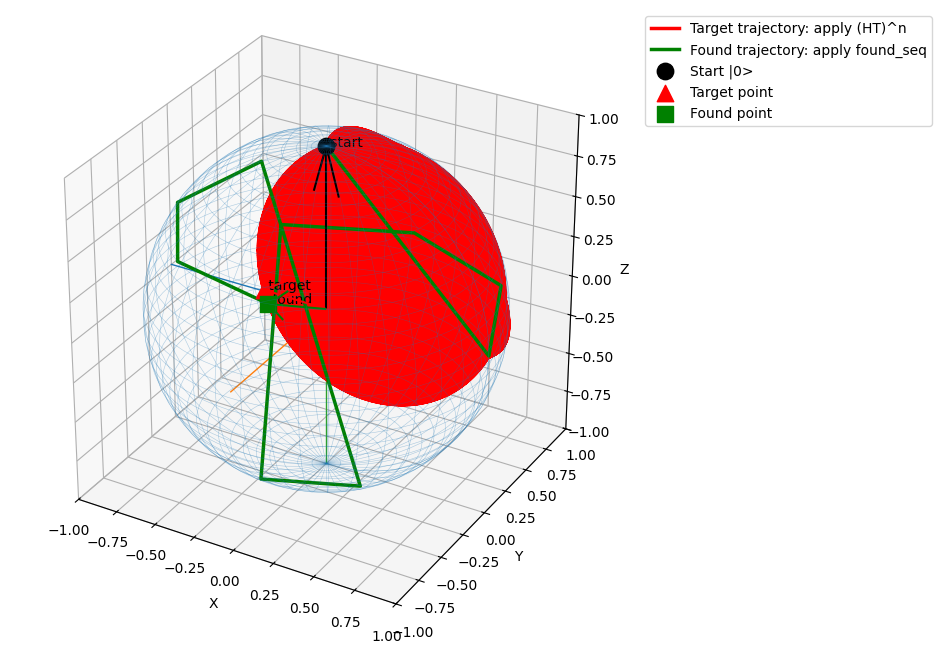

In [6]:
start_xyz = bloch_xyz_from_psi(psi0)

# target trajectory: (HT)^n 경로
target_traj = trajectory_bloch(true_seq, psi0)
target_xyz = target_traj[-1]

# found trajectory: MDP가 찾은 경로
found_seq_plot = [] if (found_seq is None) else found_seq
found_traj = trajectory_bloch(found_seq_plot, psi0) if len(found_seq_plot) > 0 else [start_xyz]
found_xyz = found_traj[-1]

print(f"[path] target_seq = {true_seq}")
print(f"[path] found_seq  = {found_seq_plot}")
print(f"[xyz] start = {start_xyz}")
print(f"[xyz] target= {target_xyz}")
print(f"[xyz] found = {found_xyz}")

# ---------- Bloch sphere wireframe (matplotlib) ----------
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.set_box_aspect([1, 1, 1])

# [설명] 구면 wireframe 생성
u = np.linspace(0, 2*np.pi, 80)
v = np.linspace(0, np.pi, 40)
xs = np.outer(np.cos(u), np.sin(v))
ys = np.outer(np.sin(u), np.sin(v))
zs = np.outer(np.ones_like(u), np.cos(v))

ax.plot_wireframe(xs, ys, zs, linewidth=0.4, alpha=0.35)

ax.plot([-1, 1], [0, 0], [0, 0], linewidth=1.0)
ax.plot([0, 0], [-1, 1], [0, 0], linewidth=1.0)
ax.plot([0, 0], [0, 0], [-1, 1], linewidth=1.0)

# ---------- Trajectories ----------
tx, ty, tz = map(np.array, zip(*target_traj))
fx, fy, fz = map(np.array, zip(*found_traj))

ax.plot(tx, ty, tz, linewidth=2.5, color="red", label="Target trajectory: apply (HT)^n")

ax.plot(fx, fy, fz, linewidth=2.5, color="green", label="Found trajectory: apply found_seq")


ax.scatter([start_xyz[0]], [start_xyz[1]], [start_xyz[2]],
           s=140, marker="o", color="black", label="Start |0>")

ax.scatter([target_xyz[0]], [target_xyz[1]], [target_xyz[2]],
           s=140, marker="^", color="red", label="Target point")

ax.scatter([found_xyz[0]], [found_xyz[1]], [found_xyz[2]],
           s=140, marker="s", color="green", label="Found point")


ax.quiver(0, 0, 0, start_xyz[0],  start_xyz[1],  start_xyz[2],  color="black", length=1.0, normalize=True)
ax.quiver(0, 0, 0, target_xyz[0], target_xyz[1], target_xyz[2], color="red",   length=1.0, normalize=True)
ax.quiver(0, 0, 0, found_xyz[0],  found_xyz[1],  found_xyz[2],  color="green", length=1.0, normalize=True)

# ---------- Labels ----------
ax.text(start_xyz[0],  start_xyz[1],  start_xyz[2],  " start",  fontsize=10)
ax.text(target_xyz[0], target_xyz[1], target_xyz[2], " target", fontsize=10)
ax.text(found_xyz[0],  found_xyz[1],  found_xyz[2],  " found",  fontsize=10)

# ---------- View / limits ----------
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
"""
plt.title(
    f"Bloch Sphere (state_prep_demo)\n"
    f"H=Ry(pi/2)Rz(pi), T=Rz(pi/4), target=(HT)^{n}, k={k}\n"
    f"target_seq={true_seq}\n"
    f"found_seq={found_seq_plot}"
)
"""
ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1.0))
plt.show()




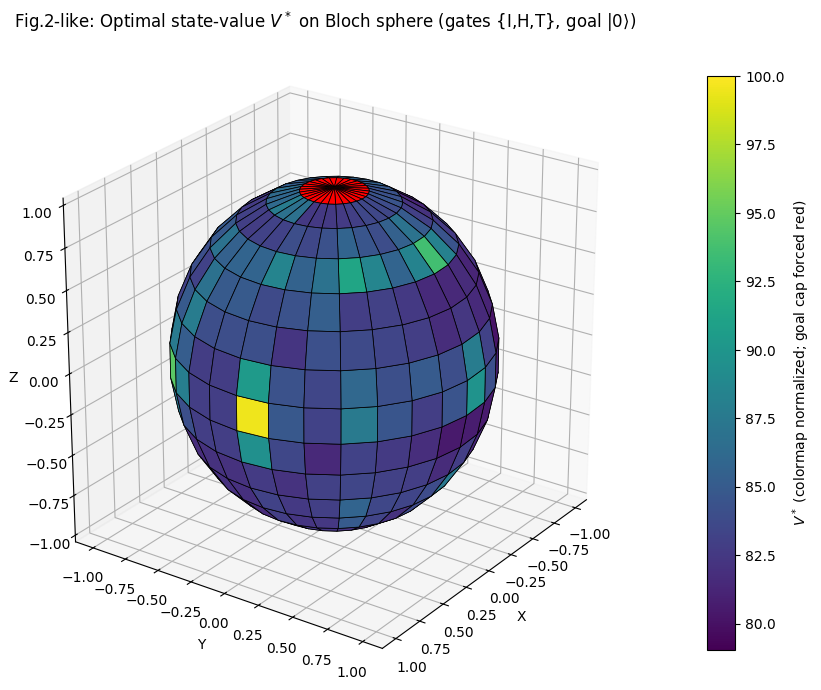

In [7]:
# =========================
# Cell (NEW): Fig.2 value landscape on Bloch sphere
#   goal = |0>  (north cap => sid=0)
# =========================

# --- parameters for Fig.2 ---
k_fig = k               
samples_fig = samples_per_state
gamma_fig = gamma
seed_fig = seed + 123

grid_fig = grid          
goal_sid = 0           

mdp_fig = MonteCarloBuilderPure(
    grid=grid_fig,
    actions=ACTIONS,
    samples_per_state=samples_fig,
    target_sid=goal_sid,
    seed=seed_fig,
    make_target_absorbing=True
).build()

policy_fig = PolicyIteration(gamma=gamma_fig, eval_tol=1e-10).solve(mdp_fig)
V = policy_fig.V  # shape (S,)

# --- build (theta,phi) patch grid for plotting ---
eps = grid_fig.eps
mmax = 2 * k_fig - 1

theta_edges = np.linspace(0.0, np.pi, k_fig + 1)           # l bins
phi_edges   = np.linspace(0.0, 2*np.pi, mmax + 1)          # m bins

Theta, Phi = np.meshgrid(theta_edges, phi_edges, indexing="ij")
X = np.sin(Theta) * np.cos(Phi)
Y = np.sin(Theta) * np.sin(Phi)
Z = np.cos(Theta)

# patch centers -> sid -> V
theta_mid = 0.5 * (theta_edges[:-1] + theta_edges[1:])
phi_mid   = 0.5 * (phi_edges[:-1] + phi_edges[1:])
Thm, Phm = np.meshgrid(theta_mid, phi_mid, indexing="ij")

sid_m = np.zeros(Thm.shape, dtype=np.int64)
for i in range(Thm.shape[0]):
    for j in range(Thm.shape[1]):
        sid_m[i, j] = grid_fig.state_id_from_angles(float(Thm[i, j]), float(Phm[i, j]))

V_m = V[sid_m]
Vn = (V_m - V_m.min()) / (V_m.max() - V_m.min() + 1e-15)

# colormap + goal cap red
cmap = plt.cm.viridis
facecolors = cmap(Vn)
facecolors[Thm < eps] = np.array([1.0, 0.0, 0.0, 1.0])  # 북극 cap(목표) 빨강

# --- plot (stable size) ---
fig = plt.figure(figsize=(8.5, 8.5))
ax = fig.add_subplot(111, projection="3d")
ax.set_box_aspect([1, 1, 1])

ax.plot_surface(
    X, Y, Z,
    rstride=1, cstride=1,
    facecolors=facecolors,
    edgecolor="k",
    linewidth=0.55,
    antialiased=True,
    shade=False
)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.view_init(elev=25, azim=35)

ax.set_title(
    "Fig.2-like: Optimal state-value $V^*$ on Bloch sphere (gates {I,H,T}, goal $|0\\rangle$)",
    fontsize=12,
    pad=14
)

# colorbar (normalized)
mappable = plt.cm.ScalarMappable(cmap=cmap)
mappable.set_array(V_m)
cb = fig.colorbar(mappable, ax=ax, shrink=0.7, pad=0.08)
cb.set_label("$V^*$ (colormap normalized; goal cap forced red)")

plt.tight_layout()
plt.show()


In [8]:
# =========================
# Cell (NEW): Fidelity computation
# Fidelity for pure states:
#   F(|psi>,|phi>) = | <psi | phi> |^2
# where <psi|phi> = psi^† phi
# =========================


if found_seq is None:
    psi_found_eval = psi0.copy()
else:
    psi_found_eval = _apply_seq(found_seq, psi0)

# normalize
psi_found_eval = psi_found_eval / np.linalg.norm(psi_found_eval)
psi_target_eval = psi_target / np.linalg.norm(psi_target)

F = float(np.abs(np.vdot(psi_found_eval, psi_target_eval))**2)

sid_found = _sid_of(grid, psi_found_eval)
same_cell = (sid_found == target_sid)

print("[fidelity]")
print(f"  F = |<found|target>|^2 = {F:.12f}")
print(f"  sid(found)={sid_found}, target_sid={target_sid}, same_cell={same_cell}")
print(f"  bloch(found) ={bloch_xyz_from_psi(psi_found_eval)}")
print(f"  bloch(target)={bloch_xyz_from_psi(psi_target_eval)}")


[fidelity]
  F = |<found|target>|^2 = 0.998479621671
  sid(found)=112, target_sid=112, same_cell=True
  bloch(found) =(0.14644660940672655, -0.853553390593274, 0.4999999999999999)
  bloch(target)=(0.1017072228911704, -0.8243808059135959, 0.5568230667393511)


In [9]:
def ket_to_rho(psi: np.ndarray) -> np.ndarray:
    psi = psi / np.linalg.norm(psi)
    return np.outer(psi, np.conjugate(psi))

def proj0() -> np.ndarray:
    return ket_to_rho(np.array([1.0+0j, 0.0+0j], dtype=np.complex128))

def apply_unitary_rho(U: np.ndarray, rho: np.ndarray) -> np.ndarray:
    return U @ rho @ np.conjugate(U).T

def bloch_xyz_from_rho(rho: np.ndarray) -> Tuple[float, float, float]:
    # (rx,ry,rz) = (Tr[rho X], Tr[rho Y], Tr[rho Z])
    X = np.array([[0, 1],[1, 0]], dtype=np.complex128)
    Y = np.array([[0, -1j],[1j, 0]], dtype=np.complex128)
    Z = np.array([[1, 0],[0, -1]], dtype=np.complex128)
    rx = float(np.real(np.trace(rho @ X)))
    ry = float(np.real(np.trace(rho @ Y)))
    rz = float(np.real(np.trace(rho @ Z)))
    return rx, ry, rz

def rho_from_bloch(r: float, theta: float, phi: float) -> np.ndarray:
    # rho = (I + r * n·sigma)/2,  |r|<=1
    nx = np.sin(theta)*np.cos(phi)
    ny = np.sin(theta)*np.sin(phi)
    nz = np.cos(theta)
    I2 = np.eye(2, dtype=np.complex128)
    X = np.array([[0, 1],[1, 0]], dtype=np.complex128)
    Y = np.array([[0, -1j],[1j, 0]], dtype=np.complex128)
    Z = np.array([[1, 0],[0, -1]], dtype=np.complex128)
    return 0.5 * (I2 + r*(nx*X + ny*Y + nz*Z))

def angles_from_bloch_vec(rx: float, ry: float, rz: float) -> Tuple[float, float, float]:
    rmag = float(np.sqrt(rx*rx + ry*ry + rz*rz))
    if rmag < 1e-15:
        return 0.0, 0.0, 0.0
    theta = float(np.arccos(np.clip(rz/rmag, -1.0, 1.0)))
    phi = float(np.mod(np.arctan2(ry, rx), 2.0*np.pi))
    return rmag, theta, phi

def fast_target_state_from_pair(n: int, pair: List[str], psi0: np.ndarray) -> np.ndarray:
    if len(pair) != 2:
        raise ValueError("pair must have length 2, e.g. ['T','H'] or ['H','T']")
    U_pair = GATESET[pair[1]] @ GATESET[pair[0]]  # apply pair[0] then pair[1]
    U_n = np.linalg.matrix_power(U_pair, int(n))
    psi_t = U_n @ psi0
    return psi_t / np.linalg.norm(psi_t)

In [10]:
# =========================
# Cell (NEW-Noise-2): Noise channels (Amplitude damping + Dephasing) via Kraus ops
# =========================

def kraus_amplitude_damping(T1: float, tau_g: float) -> List[np.ndarray]:
    """
    Standard amplitude damping with parameter gamma = 1 - exp(-tau_g/T1).
    """
    if T1 <= 0:
        raise ValueError("T1 must be > 0")
    gamma = 1.0 - np.exp(-tau_g / T1)
    gamma = float(np.clip(gamma, 0.0, 1.0))
    E0 = np.array([[1.0, 0.0],
                   [0.0, np.sqrt(1.0-gamma)]], dtype=np.complex128)
    E1 = np.array([[0.0, np.sqrt(gamma)],
                   [0.0, 0.0]], dtype=np.complex128)
    return [E0, E1]

def kraus_dephasing_extra(T1: float, T2: float, tau_g: float) -> List[np.ndarray]:
    """
    Extra pure dephasing beyond the T2=2T1 component induced by amplitude damping.
    Paper uses:
      p = 1/2 * (1 - exp(-tau_g*(1/T2 - 1/(2T1))))
    when T2 <= 2T1, and p=0 when T2=2T1.
    """
    if T2 <= 0 or T1 <= 0:
        raise ValueError("T1,T2 must be > 0")
    inv = (1.0/T2) - (1.0/(2.0*T1))
    if inv <= 0:
        p = 0.0
    else:
        p = 0.5 * (1.0 - np.exp(-tau_g * inv))
    p = float(np.clip(p, 0.0, 0.5))
    I2 = np.eye(2, dtype=np.complex128)
    Z = np.array([[1, 0],[0, -1]], dtype=np.complex128)
    A0 = np.sqrt(1.0 - p) * I2
    A1 = np.sqrt(p) * Z
    return [A0, A1]

def compose_kraus(K2: List[np.ndarray], K1: List[np.ndarray]) -> List[np.ndarray]:
    """
    Channel composition:  E = E2 ∘ E1
    If E1 has Kraus {K1_i}, E2 has {K2_j}, then E has {K2_j K1_i}.
    """
    out = []
    for B in K2:
        for A in K1:
            out.append(B @ A)
    return out

def kraus_noisy_gate(U: np.ndarray, T1: float, T2: float, tau_g: float) -> List[np.ndarray]:
    """
    Make effective Kraus for "noisy gate" following the paper's idea:
    - Build noise map (amplitude damping + dephasing)
    - Attach the unitary gate
    Effective Kraus: { U K_i } where {K_i} are Kraus of the noise channel.
    """
    K_ad = kraus_amplitude_damping(T1=T1, tau_g=tau_g)
    K_dp = kraus_dephasing_extra(T1=T1, T2=T2, tau_g=tau_g)
    K_noise = compose_kraus(K_dp, K_ad)          # dephasing ∘ amplitude_damping
    return [U @ K for K in K_noise]

def apply_kraus(rho: np.ndarray, Ks: List[np.ndarray]) -> np.ndarray:
    out = np.zeros((2,2), dtype=np.complex128)
    for K in Ks:
        out += K @ rho @ np.conjugate(K).T
    # numerical symmetrize
    out = 0.5*(out + np.conjugate(out).T)
    # clamp tiny negatives via eig fix (2x2)
    w, v = np.linalg.eigh(out)
    w = np.clip(w, 0.0, None)
    out = (v * w) @ np.conjugate(v).T
    out = out / np.trace(out)
    return out

def apply_noisy_action_to_rho(action: str, rho: np.ndarray, T1: float, T2: float, tau_g: float) -> np.ndarray:
    U = GATESET[action]
    Ks = kraus_noisy_gate(U, T1=T1, T2=T2, tau_g=tau_g)
    return apply_kraus(rho, Ks)

def sqrtm_psd_2x2(A: np.ndarray) -> np.ndarray:
    # Hermitian PSD 2x2 sqrt via eig
    w, v = np.linalg.eigh(0.5*(A + np.conjugate(A).T))
    w = np.clip(w, 0.0, None)
    return (v * np.sqrt(w)) @ np.conjugate(v).T

def fidelity_mixed(rho: np.ndarray, sigma: np.ndarray) -> float:
    # Eq.(12): F(rho,sigma) = Tr sqrt( sqrt(rho) sigma sqrt(rho) )
    sr = sqrtm_psd_2x2(rho)
    X = sr @ sigma @ sr
    sX = sqrtm_psd_2x2(X)
    F = float(np.real(np.trace(sX)))
    # numerical clamp
    return float(np.clip(F, 0.0, 1.0))


In [11]:
# =========================
# Cell A: Mixed-state grid for noisy Bloch ball
#   s = (l, m, q)  where
#     theta bin: l = 0..k-1   (eps = pi/k)
#     phi   bin: m = 0..2k-2  (eps = pi/k)  -> total (2k-1) bins
#     r     bin: q = 0..k-1   (r in [q/k, (q+1)/k))
#
#   total states: k * (2k-1) * k = k^2(2k-1)
# =========================

@dataclass(frozen=True)
class MixedGrid:
    k: int

    @property
    def eps(self) -> float:
        return np.pi / self.k

    @property
    def m_bins(self) -> int:
        return 2 * self.k - 1

    def num_states(self) -> int:
        return self.k * self.m_bins * self.k

    def encode(self, l: int, m: int, q: int) -> int:
        return (l * self.m_bins + m) * self.k + q

    def decode(self, sid: int) -> Tuple[int, int, int]:
        q = sid % self.k
        t = sid // self.k
        m = t % self.m_bins
        l = t // self.m_bins
        return int(l), int(m), int(q)

    def state_id_from_r_theta_phi(self, r: float, theta: float, phi: float) -> int:
        r = float(np.clip(r, 0.0, 1.0))
        theta = float(np.clip(theta, 0.0, np.pi))
        phi = float(np.mod(phi, 2.0 * np.pi))
        eps = self.eps

        l = int(theta // eps)
        l = min(max(l, 0), self.k - 1)

        m = int(phi // eps)
        m = min(max(m, 0), self.m_bins - 1)

        q = int(np.floor(r * self.k))
        q = min(max(q, 0), self.k - 1)

        return self.encode(l, m, q)

    def sample_r_theta_phi_in_cell(self, sid: int, rng: np.random.Generator) -> Tuple[float, float, float]:
        l, m, q = self.decode(sid)
        eps = self.eps

        th = rng.uniform(l * eps, (l + 1) * eps)
        ph = rng.uniform(m * eps, (m + 1) * eps)

        r_lo = q / self.k
        r_hi = (q + 1) / self.k
        r = rng.uniform(r_lo, r_hi)

        return float(r), float(th), float(ph)


In [12]:
# =========================
# Cell PATCH: 진행 로그 + Kraus 캐시까지 포함한 빌더(새 클래스)
#   - 기존 MonteCarloBuilderMixedNoisy는 그대로 두고
#   - debug/fast 버전 클래스를 새로 정의해서 이걸로 build() 하자
# =========================

@dataclass
class MonteCarloBuilderMixedNoisyFast:
    grid: MixedGrid
    actions: List[str]
    samples_per_state: int
    seed: int = 0

    T1: float = 25e-6
    T2: float = 20e-6
    tau_g: float = 50e-9

    make_goal_absorbing: bool = True
    goal_l: int = 0
    goal_min_q: Optional[int] = None

    progress_every: int = 200  # 상태 몇 개마다 출력할지

    def build(self) -> MDP:
        rng = np.random.default_rng(self.seed)
        S = self.grid.num_states()

        # --- (핵심) Kraus를 액션별로 한 번만 만들고 재사용 ---
        Ks_cache = {}
        for a in self.actions:
            U = GATESET[a]
            Ks_cache[a] = kraus_noisy_gate(U, T1=self.T1, T2=self.T2, tau_g=self.tau_g)

        transitions: Dict[str, List[List[Transition]]] = {
            a: [list() for _ in range(S)] for a in self.actions
        }

        def is_goal(sid: int) -> bool:
            l, m, q = self.grid.decode(sid)
            if l != self.goal_l:
                return False
            if self.goal_min_q is None:
                return True
            return q >= int(self.goal_min_q)

        for s in range(S):
            if self.progress_every and (s % self.progress_every == 0):
                print(f"[build] s={s}/{S}")

            if self.make_goal_absorbing and is_goal(s):
                for a in self.actions:
                    transitions[a][s] = [Transition(s2=s, p=1.0, r=1.0)]
                continue

            for a in self.actions:
                counts: Dict[int, int] = {}
                rsum: Dict[int, float] = {}
                Ks = Ks_cache[a]

                for _ in range(self.samples_per_state):
                    r, th, ph = self.grid.sample_r_theta_phi_in_cell(s, rng)
                    rho = rho_from_bloch(r, th, ph)

                    # --- cached Kraus apply (apply_noisy_action_to_rho 대신) ---
                    rho2 = apply_kraus(rho, Ks)

                    rx, ry, rz = bloch_xyz_from_rho(rho2)
                    r2, th2, ph2 = angles_from_bloch_vec(rx, ry, rz)
                    s2 = self.grid.state_id_from_r_theta_phi(r2, th2, ph2)

                    counts[s2] = counts.get(s2, 0) + 1
                    _, _, q2 = self.grid.decode(s2)
                    rew = float(q2) / float(self.grid.k)   # paper-style reward
                    rsum[s2] = rsum.get(s2, 0.0) + rew

                out: List[Transition] = []
                denom = float(self.samples_per_state)
                for s2, c in counts.items():
                    out.append(Transition(
                        s2=s2,
                        p=c / denom,
                        r=rsum[s2] / float(c)
                    ))

                psum = sum(tr.p for tr in out)
                if psum <= 0:
                    transitions[a][s] = [Transition(s2=s, p=1.0, r=0.0)]
                else:
                    transitions[a][s] = [Transition(tr.s2, tr.p / psum, tr.r) for tr in out]

        return MDP(num_states=S, actions=self.actions, transitions=transitions)


In [13]:
# =========================
# Cell C (REPLACE): 위 fast 빌더로 실행 (진행 로그가 여기서 찍힘)
# =========================

k_noisy = k              
samples_per_state_noisy = 80
gamma_noisy = 0.99
seed_noisy = 123

T1 = 25e-6
T2 = 20e-6
tau_g = 50e-9

grid_noisy = MixedGrid(k=k_noisy)

mdp_noisy = MonteCarloBuilderMixedNoisyFast(
    grid=grid_noisy,
    actions=ACTIONS,
    samples_per_state=samples_per_state_noisy,
    seed=seed_noisy,
    T1=T1, T2=T2, tau_g=tau_g,
    make_goal_absorbing=True,
    goal_l=0,
    goal_min_q=None,
    progress_every=200,
).build()

policy_noisy = PolicyIteration(gamma=gamma_noisy, eval_tol=1e-10).solve(mdp_noisy)
V_noisy = policy_noisy.V

print("[noisy fig2] done")
print("  k =", k_noisy, "S =", grid_noisy.num_states(), "samples =", samples_per_state_noisy)
print("  V range =", float(V_noisy.min()), float(V_noisy.max()))


[build] s=0/6525
[build] s=200/6525
[build] s=400/6525
[build] s=600/6525
[build] s=800/6525
[build] s=1000/6525
[build] s=1200/6525
[build] s=1400/6525
[build] s=1600/6525
[build] s=1800/6525
[build] s=2000/6525
[build] s=2200/6525
[build] s=2400/6525
[build] s=2600/6525
[build] s=2800/6525
[build] s=3000/6525
[build] s=3200/6525
[build] s=3400/6525
[build] s=3600/6525
[build] s=3800/6525
[build] s=4000/6525
[build] s=4200/6525
[build] s=4400/6525
[build] s=4600/6525
[build] s=4800/6525
[build] s=5000/6525
[build] s=5200/6525
[build] s=5400/6525
[build] s=5600/6525
[build] s=5800/6525
[build] s=6000/6525
[build] s=6200/6525
[build] s=6400/6525
[noisy fig2] done
  k = 15 S = 6525 samples = 80
  V range = 80.48338607612355 99.9999999999992


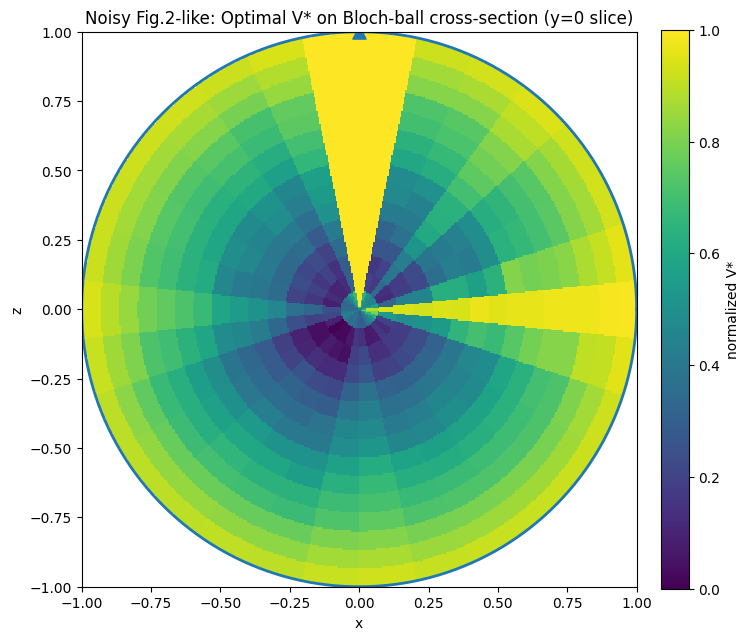

In [14]:
# =========================
# Cell D: Bloch ball cross-section (y = 0 slice) visualization
#   - 내부를 보려면 표면이 아니라 "단면 디스크"를 색칠해야 함
#   - 여기서는 x-z plane (y=0)에서 x^2+z^2<=1 영역에 대해 V*(sid(x,0,z))를 표시
# =========================

def sid_from_xyz_on_slice(grid: MixedGrid, x: float, y: float, z: float) -> int:
    r = float(np.sqrt(x*x + y*y + z*z))
    if r < 1e-15:
        theta, phi = 0.0, 0.0
    else:
        theta = float(np.arccos(np.clip(z/r, -1.0, 1.0)))
        phi = float(np.mod(np.arctan2(y, x), 2.0*np.pi))
    return grid.state_id_from_r_theta_phi(r, theta, phi)

N = 400
xs = np.linspace(-1.0, 1.0, N)
zs = np.linspace(-1.0, 1.0, N)

Vmap = np.full((N, N), np.nan, dtype=np.float64)

for ix, x in enumerate(xs):
    for iz, z in enumerate(zs):
        if x*x + z*z <= 1.0 + 1e-12:
            sid = sid_from_xyz_on_slice(grid_noisy, x, 0.0, z)
            Vmap[iz, ix] = V_noisy[sid]

vmin = np.nanmin(Vmap)
vmax = np.nanmax(Vmap)
Vn = (Vmap - vmin) / (vmax - vmin + 1e-15)

fig, ax = plt.subplots(figsize=(7.6, 7.0))
im = ax.imshow(
    Vn,
    extent=[-1, 1, -1, 1],
    origin="lower",
    interpolation="nearest",
    aspect="equal",
)

# disk boundary (x^2+z^2=1)
t = np.linspace(0, 2*np.pi, 600)
ax.plot(np.cos(t), np.sin(t), linewidth=2.0)

# north pole marker in this slice: (x,z)=(0,1)
ax.scatter([0.0], [1.0], s=90, marker="^")

ax.set_xlabel("x")
ax.set_ylabel("z")
ax.set_title("Noisy Fig.2-like: Optimal V* on Bloch-ball cross-section (y=0 slice)")

cb = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cb.set_label("normalized V*")

plt.tight_layout()
plt.show()


In [15]:
# =========================
# Cell (NOISY-HELPERS): rho trajectory with cached Kraus
# =========================

def make_kraus_cache(T1: float, T2: float, tau_g: float, actions: List[str]) -> Dict[str, List[np.ndarray]]:
    cache = {}
    for a in actions:
        U = GATESET[a]
        cache[a] = kraus_noisy_gate(U, T1=T1, T2=T2, tau_g=tau_g)  # already defined in your code
    return cache

def trajectory_bloch_noisy(seq: List[str], rho0: np.ndarray, Ks_cache: Dict[str, List[np.ndarray]]) -> List[Tuple[float,float,float]]:
    pts = [bloch_xyz_from_rho(rho0)]  # already defined in your code
    rho = rho0.copy()
    for a in seq:
        rho = apply_kraus(rho, Ks_cache[a])  # already defined in your code
        pts.append(bloch_xyz_from_rho(rho))
    return pts


[noisy path] target_seq = ['T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'T'

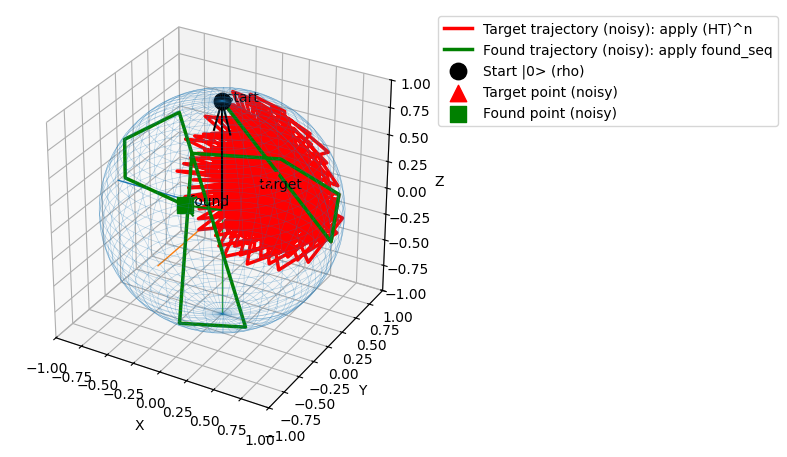

In [16]:
# =========================
# Cell (NOISY-EXPERIMENT): same plotting style, but under noise (rho dynamics)
# =========================

# ---- noise params ----
T1 = 25e-6
T2 = 20e-6
tau_g = 50e-9

# ---- Kraus cache (speed) ----
Ks_cache = make_kraus_cache(T1=T1, T2=T2, tau_g=tau_g, actions=ACTIONS)

# ---- initial state: rho0 from psi0 ----
rho0 = ket_to_rho(psi0)  # already defined in your code

# ---- start point (noisy) ----
start_xyz = bloch_xyz_from_rho(rho0)

# target trajectory: (HT)^n under noise
target_traj = trajectory_bloch_noisy(true_seq, rho0, Ks_cache)
target_xyz = target_traj[-1]

# found trajectory: found_seq under noise
found_seq_plot = [] if (found_seq is None) else found_seq
found_traj = trajectory_bloch_noisy(found_seq_plot, rho0, Ks_cache) if len(found_seq_plot) > 0 else [start_xyz]
found_xyz = found_traj[-1]

print(f"[noisy path] target_seq = {true_seq}")
print(f"[noisy path] found_seq  = {found_seq_plot}")
print(f"[noisy xyz] start = {start_xyz}")
print(f"[noisy xyz] target= {target_xyz}")
print(f"[noisy xyz] found = {found_xyz}")

# ---------- Bloch sphere wireframe (unit sphere boundary) ----------
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.set_box_aspect([1, 1, 1])

u = np.linspace(0, 2*np.pi, 80)
v = np.linspace(0, np.pi, 40)
xs = np.outer(np.cos(u), np.sin(v))
ys = np.outer(np.sin(u), np.sin(v))
zs = np.outer(np.ones_like(u), np.cos(v))
ax.plot_wireframe(xs, ys, zs, linewidth=0.4, alpha=0.35)

ax.plot([-1, 1], [0, 0], [0, 0], linewidth=1.0)
ax.plot([0, 0], [-1, 1], [0, 0], linewidth=1.0)
ax.plot([0, 0], [0, 0], [-1, 1], linewidth=1.0)

# ---------- Trajectories ----------
tx, ty, tz = map(np.array, zip(*target_traj))
fx, fy, fz = map(np.array, zip(*found_traj))

ax.plot(tx, ty, tz, linewidth=2.5, color="red",   label="Target trajectory (noisy): apply (HT)^n")
ax.plot(fx, fy, fz, linewidth=2.5, color="green", label="Found trajectory (noisy): apply found_seq")

# markers
ax.scatter([start_xyz[0]], [start_xyz[1]], [start_xyz[2]],
           s=140, marker="o", color="black", label="Start |0> (rho)")

ax.scatter([target_xyz[0]], [target_xyz[1]], [target_xyz[2]],
           s=140, marker="^", color="red", label="Target point (noisy)")

ax.scatter([found_xyz[0]], [found_xyz[1]], [found_xyz[2]],
           s=140, marker="s", color="green", label="Found point (noisy)")

ax.quiver(0, 0, 0, start_xyz[0],  start_xyz[1],  start_xyz[2],  color="black", length=1.0, normalize=True)
ax.quiver(0, 0, 0, target_xyz[0], target_xyz[1], target_xyz[2], color="red",   length=1.0, normalize=True)
ax.quiver(0, 0, 0, found_xyz[0],  found_xyz[1],  found_xyz[2],  color="green", length=1.0, normalize=True)

# labels
ax.text(start_xyz[0],  start_xyz[1],  start_xyz[2],  " start",  fontsize=10)
ax.text(target_xyz[0], target_xyz[1], target_xyz[2], " target", fontsize=10)
ax.text(found_xyz[0],  found_xyz[1],  found_xyz[2],  " found",  fontsize=10)

# view / limits
ax.set_xlim([-1, 1]); ax.set_ylim([-1, 1]); ax.set_zlim([-1, 1])
ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")

ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1.0))
plt.tight_layout()
plt.show()


In [17]:
# =========================
# Cell (NOISY): Fidelity computation under noise (density matrices)
#   Mixed-state fidelity (Uhlmann):
#     F(ρ,σ) = Tr sqrt( sqrt(ρ) σ sqrt(ρ) )
#   (네 코드의 fidelity_mixed()를 그대로 사용)
# =========================

# ---- noise params (same as noisy experiment) ----
T1 = 25e-6
T2 = 20e-6
tau_g = 50e-9

# ---- Kraus cache (speed) ----
Ks_cache = {}
for a in ACTIONS:
    U = GATESET[a]
    Ks_cache[a] = kraus_noisy_gate(U, T1=T1, T2=T2, tau_g=tau_g)

def apply_noisy_seq_to_rho(seq: List[str], rho0: np.ndarray) -> np.ndarray:
    rho = rho0.copy()
    for a in seq:
        rho = apply_kraus(rho, Ks_cache[a])
    return rho

# ---- build noisy endpoints ----
rho0 = ket_to_rho(psi0)

# target endpoint under noise
rho_target_eval = apply_noisy_seq_to_rho(true_seq, rho0)

# found endpoint under noise
if found_seq is None:
    rho_found_eval = rho0.copy()
else:
    rho_found_eval = apply_noisy_seq_to_rho(found_seq, rho0)

# ---- fidelity (mixed) ----
F_noisy = float(fidelity_mixed(rho_found_eval, rho_target_eval))

# ---- Bloch vectors (for debugging/interpretation) ----
bf = bloch_xyz_from_rho(rho_found_eval)
bt = bloch_xyz_from_rho(rho_target_eval)

print("[noisy fidelity]")
print(f"  F_mixed(found, target) = {F_noisy:.12f}")
print(f"  bloch(found)  = {bf}, |r_found|={float(np.linalg.norm(np.array(bf))):.6f}")
print(f"  bloch(target) = {bt}, |r_target|={float(np.linalg.norm(np.array(bt))):.6f}")


[noisy fidelity]
  F_mixed(found, target) = 0.885932830115
  bloch(found)  = (0.14481033951337147, -0.8283157656269521, 0.5011641677529344), |r_found|=0.978899
  bloch(target) = (0.40436825708182383, -0.1739220506949243, 0.40601571869850245), |r_target|=0.598842
